In [45]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import seaborn as sns # More snazzy plotting library

In [2]:
pd.options.display.max_columns = 40

In [3]:
#open the file
file_path = "/home/user/projects/data_mining/predictive_data_mining/logistic_regression/working_dataset.csv"
dta = pd.read_csv(file_path)
dta.gross.median()

25517500.0

In [26]:
dta = dta.reindex_axis(sorted(dta.columns), axis=1)
dta.head(5)

,actor_1_facebook_likes,actor_1_name,actor_2_facebook_likes,actor_2_name,actor_3_facebook_likes,actor_3_name,aspect_ratio,budget,cast_total_facebook_likes,color,content_rating,country,director_facebook_likes,director_name,duration,facenumber_in_poster,genres,gross,imdb_score,language,movie_facebook_likes,movie_imdb_link,movie_title,num_critic_for_reviews,num_user_for_reviews,num_voted_users,plot_keywords,title_year
0,1000.0,CCH Pounder,936.0,Joel David Moore,855.0,Wes Studi,1.78,237000000.0,4834,Color,PG-13,USA,0.0,James Cameron,178.0,0.0,Action|Adventure|Fantasy|Sci-Fi,760505847.0,7.9,English,33000,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,Avatar,723.0,3054.0,886204,avatar|future|marine|native|paraplegic,2009.0
1,40000.0,Johnny Depp,5000.0,Orlando Bloom,1000.0,Jack Davenport,2.35,300000000.0,48350,Color,PG-13,USA,563.0,Gore Verbinski,169.0,0.0,Action|Adventure|Fantasy,309404152.0,7.1,English,0,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,Pirates of the Caribbean: At World's End,302.0,1238.0,471220,goddess|marriage ceremony|marriage proposal|pi...,2007.0
2,11000.0,Christoph Waltz,393.0,Rory Kinnear,161.0,Stephanie Sigman,2.35,245000000.0,11700,Color,PG-13,UK,0.0,Sam Mendes,148.0,1.0,Action|Adventure|Thriller,200074175.0,6.8,English,85000,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,Spectre,602.0,994.0,275868,bomb|espionage|sequel|spy|terrorist,2015.0
3,27000.0,Tom Hardy,23000.0,Christian Bale,23000.0,Joseph Gordon-Levitt,2.35,250000000.0,106759,Color,PG-13,USA,22000.0,Christopher Nolan,164.0,0.0,Action|Thriller,448130642.0,8.5,English,164000,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,The Dark Knight Rises,813.0,2701.0,1144337,deception|imprisonment|lawlessness|police offi...,2012.0
4,131.0,Doug Walker,12.0,Rob Walker,NaN,NaN,NaN,NaN,143,NaN,NaN,NaN,131.0,Doug Walker,NaN,0.0,Documentary,NaN,7.1,NaN,0,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,Star Wars: Episode VII - The Force Awakens ...,NaN,NaN,8,NaN,NaN


In [30]:
#clean up data non numeric rows
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in dta.iteritems():
    if type(colvalue[1]) == str:
        #if colname not in str_list:
            str_list.append(colname)
# Get to the numeric columns by inversion
num_list = dta.columns.difference(str_list)
#USe only the numeriv values
dta_clean = dta[num_list]
#remove the null values, that is fill NaN with there - FIXME: Rihards, naive implementation
dta_clean = dta_clean.fillna(value=0, axis=1)
dta_clean = dta_clean.reindex_axis(sorted(dta_clean.columns), axis=1)
dta_clean.head(10)

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,aspect_ratio,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year
0,1000.0,936.0,855.0,1.78,237000000.0,4834,0.0,178.0,0.0,760505847.0,7.9,33000,723.0,3054.0,886204,2009.0
1,40000.0,5000.0,1000.0,2.35,300000000.0,48350,563.0,169.0,0.0,309404152.0,7.1,0,302.0,1238.0,471220,2007.0
2,11000.0,393.0,161.0,2.35,245000000.0,11700,0.0,148.0,1.0,200074175.0,6.8,85000,602.0,994.0,275868,2015.0
3,27000.0,23000.0,23000.0,2.35,250000000.0,106759,22000.0,164.0,0.0,448130642.0,8.5,164000,813.0,2701.0,1144337,2012.0
4,131.0,12.0,0.0,0.00,0.0,143,131.0,0.0,0.0,0.0,7.1,0,0.0,0.0,8,0.0
5,640.0,632.0,530.0,2.35,263700000.0,1873,475.0,132.0,1.0,73058679.0,6.6,24000,462.0,738.0,212204,2012.0
6,24000.0,11000.0,4000.0,2.35,258000000.0,46055,0.0,156.0,0.0,336530303.0,6.2,0,392.0,1902.0,383056,2007.0
7,799.0,553.0,284.0,1.85,260000000.0,2036,15.0,100.0,1.0,200807262.0,7.8,29000,324.0,387.0,294810,2010.0
8,26000.0,21000.0,19000.0,2.35,250000000.0,92000,0.0,141.0,4.0,458991599.0,7.5,118000,635.0,1117.0,462669,2015.0
9,25000.0,11000.0,10000.0,2.35,250000000.0,58753,282.0,153.0,3.0,301956980.0,7.5,10000,375.0,973.0,321795,2009.0


In [35]:
#clean up data from zero rows 
for colname, colvalue in dta_clean.iteritems():
    if colname != 'facenumber_in_poster':
        dta_clean = dta_clean[dta_clean[colname] != 0]
dta_clean.head(10)

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,aspect_ratio,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year
3,27000.0,23000.0,23000.0,2.35,250000000.0,106759,22000.0,164.0,0.0,448130642.0,8.5,164000,813.0,2701.0,1144337,2012.0
5,640.0,632.0,530.0,2.35,263700000.0,1873,475.0,132.0,1.0,73058679.0,6.6,24000,462.0,738.0,212204,2012.0
7,799.0,553.0,284.0,1.85,260000000.0,2036,15.0,100.0,1.0,200807262.0,7.8,29000,324.0,387.0,294810,2010.0
9,25000.0,11000.0,10000.0,2.35,250000000.0,58753,282.0,153.0,3.0,301956980.0,7.5,10000,375.0,973.0,321795,2009.0
13,40000.0,5000.0,1000.0,2.35,225000000.0,48486,563.0,151.0,2.0,423032628.0,7.3,5000,313.0,1832.0,522040,2006.0
14,40000.0,2000.0,1000.0,2.35,215000000.0,45757,563.0,150.0,1.0,89289910.0,6.5,48000,450.0,711.0,181792,2013.0
18,40000.0,11000.0,1000.0,2.35,250000000.0,54083,252.0,136.0,4.0,241063875.0,6.7,58000,448.0,484.0,370704,2011.0
19,10000.0,816.0,718.0,1.85,225000000.0,12572,188.0,106.0,1.0,179020854.0,6.8,40000,451.0,341.0,268154,2012.0
21,15000.0,10000.0,963.0,2.35,230000000.0,28489,464.0,153.0,0.0,262030663.0,7.0,56000,599.0,1225.0,451803,2012.0
27,21000.0,19000.0,11000.0,2.35,250000000.0,64798,94.0,147.0,0.0,407197282.0,8.2,72000,516.0,1022.0,272670,2016.0


In [37]:
#add new binary column which represents if gross is above the median gross or below
dta_clean['gross_median'] = (dta_clean.gross >= dta_clean.gross.median()).astype(int)
dta_clean.groupby('gross_median').count()

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,aspect_ratio,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year
gross_median,,,,,,,,,,,,,,,,
0,822,822,822,822,822,822,822,822,822,822,822,822,822,822,822,822
1,822,822,822,822,822,822,822,822,822,822,822,822,822,822,822,822


In [39]:
dta_clean.groupby('gross_median').mean()

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,aspect_ratio,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year
gross_median,,,,,,,,,,,,,,,,
0,5224.698297,1220.974453,513.064477,2.066715,4.208863e+07,7631.384428,473.900243,105.708029,1.423358,8.034501e+06,6.202068,6666.590024,113.715328,159.991484,40165.950122,2002.418491
1,10137.615572,3150.734793,1269.564477,2.161436,5.979957e+07,15914.428224,1727.557178,112.388078,1.368613,9.394518e+07,6.584428,25060.484185,242.993917,435.507299,178000.182482,2006.821168


In [13]:
# show plots in the notebook
%matplotlib inline

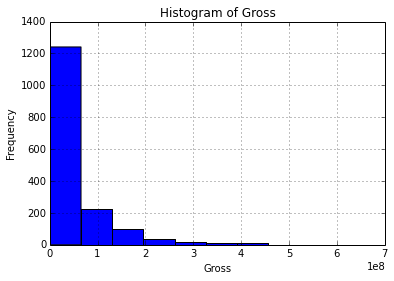

In [40]:
# histogram of gross
dta_clean.gross.hist()
plt.title('Histogram of Gross')
plt.xlabel('Gross')
plt.ylabel('Frequency')

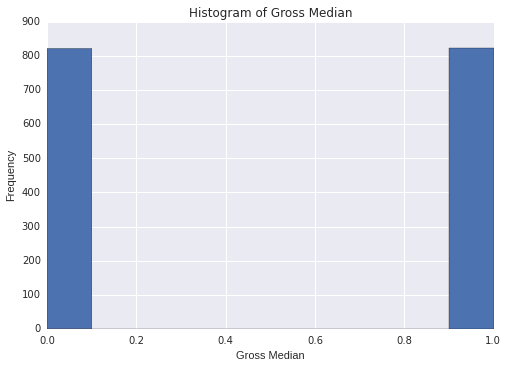

In [86]:
# histogram of gross median
dta_clean.gross_median.hist()
plt.title('Histogram of Gross Median')
plt.xlabel('Gross Median')
plt.ylabel('Frequency')

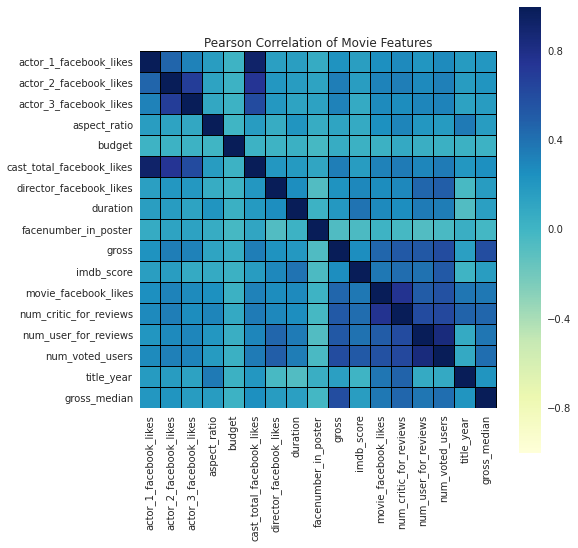

In [46]:
#plot pearsons coleration
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))
plt.title('Pearson Correlation of Movie Features')
# Draw the heatmap using seaborn
sns.heatmap(dta_clean.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black')

In [57]:
# create dataframes suitable for regression, with seperating predictors and outcomes. the predictors can be wrapped with a matching function in order to improve coleration linearity
y, X = dmatrices('gross_median ~ actor_1_facebook_likes + actor_2_facebook_likes + \
                 actor_3_facebook_likes + aspect_ratio + budget + cast_total_facebook_likes + \
                 director_facebook_likes + duration + facenumber_in_poster + imdb_score + \
                 movie_facebook_likes + num_critic_for_reviews + num_user_for_reviews + num_voted_users + title_year',
                 dta_clean, return_type="dataframe")

In [58]:
# flatten y into a 1-D array
y = np.ravel(y)

In [63]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.74695863746958635

In [61]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[-1.7279928527e-07]
1,actor_1_facebook_likes,[-1.00699126673e-05]
2,actor_2_facebook_likes,[1.55406732213e-05]
3,actor_3_facebook_likes,[3.3524637875e-07]
4,aspect_ratio,[-3.4406216015e-07]
5,budget,[-7.4580091388e-11]
6,cast_total_facebook_likes,[9.61155330356e-06]
7,director_facebook_likes,[-7.63283724857e-06]
8,duration,[-1.8110411295e-05]
9,facenumber_in_poster,[-2.58217920562e-07]


In [80]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)
print X_train
print y_train

      Intercept  actor_1_facebook_likes  actor_2_facebook_likes  \
235         1.0                 11000.0                 10000.0   
3344        1.0                  8000.0                   327.0   
110         1.0                   531.0                    82.0   
2959        1.0                  1000.0                   844.0   
4583        1.0                   855.0                   577.0   
590         1.0                 12000.0                  3000.0   
1282        1.0                   783.0                   754.0   
799         1.0                   889.0                   290.0   
3938        1.0                 12000.0                  1000.0   
5029        1.0                    89.0                    13.0   
5004        1.0                    32.0                    17.0   
106         1.0                 40000.0                 25000.0   
3353        1.0                  2000.0                   716.0   
983         1.0                 21000.0                  3000.

In [68]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print predicted

[ 0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  0.  1.  0.
  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  1.  0.  1.  1.  1.  0.  0.
  1.  1.  1.  0.  1.  0.  0.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.
  1.  1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.
  0.  0.  0.  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.
  0.  0.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.  1.
  1.  0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  1.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.
  0.  0.  0.  0.  1.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0

In [69]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print probs

[[  7.53542419e-01   2.46457581e-01]
 [  7.64116515e-01   2.35883485e-01]
 [  7.02610730e-01   2.97389270e-01]
 [  7.76117963e-01   2.23882037e-01]
 [  2.61694932e-01   7.38305068e-01]
 [  7.44742364e-01   2.55257636e-01]
 [  4.05557688e-01   5.94442312e-01]
 [  7.69664137e-01   2.30335863e-01]
 [  7.56697443e-01   2.43302557e-01]
 [  7.55213110e-01   2.44786890e-01]
 [  1.61247352e-01   8.38752648e-01]
 [  4.24459103e-02   9.57554090e-01]
 [  9.46935159e-02   9.05306484e-01]
 [  7.24076950e-01   2.75923050e-01]
 [  3.58633082e-01   6.41366918e-01]
 [  5.84329026e-01   4.15670974e-01]
 [  3.74600010e-01   6.25399990e-01]
 [  7.35192264e-01   2.64807736e-01]
 [  7.33567380e-01   2.66432620e-01]
 [  1.30626166e-01   8.69373834e-01]
 [  2.84527718e-01   7.15472282e-01]
 [  7.25851434e-01   2.74148566e-01]
 [  7.67012483e-01   2.32987517e-01]
 [  3.77709145e-01   6.22290855e-01]
 [  2.10494199e-03   9.97895058e-01]
 [  7.19352979e-01   2.80647021e-01]
 [  7.67816850e-01   2.32183150e-01]
 

In [71]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.730769230769
0.844291622899


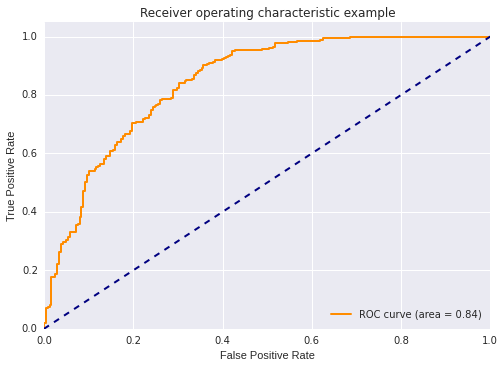

In [87]:
fpr, tpr, threshold = metrics.roc_curve(y_test, probs[:, 1])
roc_auc = metrics.auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

In [89]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.8313253   0.76506024  0.77439024  0.6402439   0.69512195  0.65243902
  0.7804878   0.62195122  0.68902439  0.76219512]
0.721223920071
